In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading 

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset (replace 'your_dataset.csv' with the actual dataset file)
data = pd.read_csv('processed_data_PCA.csv')

# Assuming the last column is the target variable (y), and the rest are features (X)
X = data.drop('y', axis=1)  # Assuming 'y' is your target column
y = data['y']

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Example: Check the shape of the datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (36167, 53)
X_test shape: (9042, 53)


In [3]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Model 

Epoch 1/20, Loss: 0.5581, Accuracy: 0.7171
Epoch 2/20, Loss: 0.5152, Accuracy: 0.7503
Epoch 3/20, Loss: 0.4905, Accuracy: 0.7644
Epoch 4/20, Loss: 0.4662, Accuracy: 0.7786
Epoch 5/20, Loss: 0.4445, Accuracy: 0.7907
Epoch 6/20, Loss: 0.4226, Accuracy: 0.8081
Epoch 7/20, Loss: 0.4036, Accuracy: 0.8203
Epoch 8/20, Loss: 0.3883, Accuracy: 0.8282
Epoch 9/20, Loss: 0.3730, Accuracy: 0.8370
Epoch 10/20, Loss: 0.3585, Accuracy: 0.8455
Epoch 11/20, Loss: 0.3474, Accuracy: 0.8522
Epoch 12/20, Loss: 0.3374, Accuracy: 0.8560
Epoch 13/20, Loss: 0.3294, Accuracy: 0.8580
Epoch 14/20, Loss: 0.3205, Accuracy: 0.8634
Epoch 15/20, Loss: 0.3141, Accuracy: 0.8667
Epoch 16/20, Loss: 0.3071, Accuracy: 0.8715
Epoch 17/20, Loss: 0.3035, Accuracy: 0.8735
Epoch 18/20, Loss: 0.2993, Accuracy: 0.8729
Epoch 19/20, Loss: 0.2919, Accuracy: 0.8782
Epoch 20/20, Loss: 0.2902, Accuracy: 0.8793


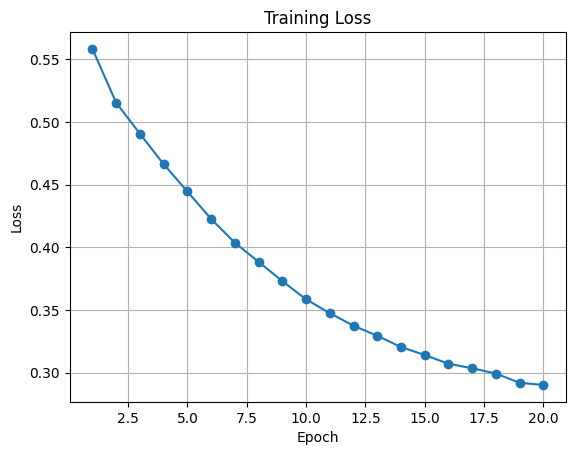

Training Accuracy: 0.8847946448121617
Test Accuracy: 0.8454987834549879
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      7951
           1       0.38      0.45      0.41      1091

    accuracy                           0.85      9042
   macro avg       0.65      0.67      0.66      9042
weighted avg       0.86      0.85      0.85      9042



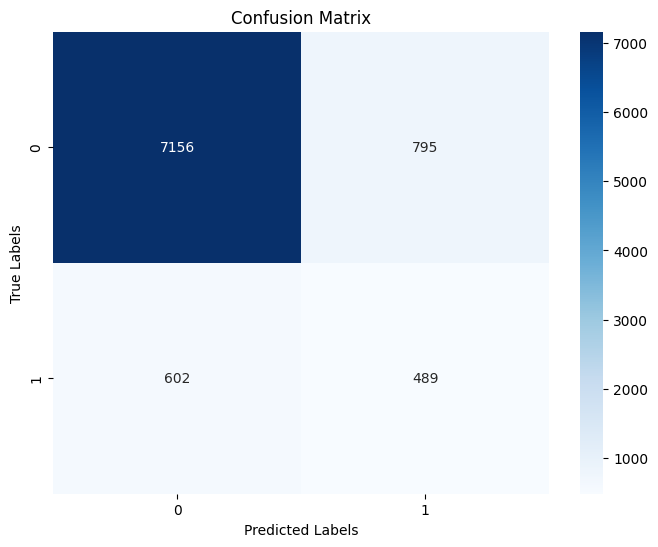

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure reproducibility
torch.manual_seed(42)

# Convert preprocessed DataFrames to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Neural Network Model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First hidden layer
        self.relu = nn.ReLU()                         # Activation function
        self.fc2 = nn.Linear(hidden_size, output_size) # Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define model parameters
input_size = X_train_resampled.shape[1]  # Number of features
hidden_size = 64               # Number of neurons in the hidden layer
output_size = 2  # Number of output classes


# Initialize the model
model = NeuralNet(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training the model
epochs = 20
losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    epoch_accuracy = correct / total
    losses.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}")

# Plot training loss
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

# Evaluation
model.eval()
y_train_pred = []
y_train_true = []
y_test_pred = []
y_test_true = []

# Training Accuracy
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_train_pred.extend(predicted.cpu().numpy())
        y_train_true.extend(y_batch.cpu().numpy())

print("Training Accuracy:", accuracy_score(y_train_true, y_train_pred))

# Test Accuracy
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_test_pred.extend(predicted.cpu().numpy())
        y_test_true.extend(y_batch.cpu().numpy())

print("Test Accuracy:", accuracy_score(y_test_true, y_test_pred))

# Classification Report for Test Data
print("Classification Report:")
print(classification_report(y_test_true, y_test_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_true, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# # Save the model
# torch.save(model.state_dict(), 'neural_net_model.pth')
# print("Model saved as 'neural_net_model.pth'")


pca model

# Tunning 

Early stopping triggered after 8 epochs.
Hidden Size: 32, LR: 0.01, Batch Size: 16, Val Accuracy: 0.7509
Early stopping triggered after 8 epochs.
Hidden Size: 32, LR: 0.01, Batch Size: 32, Val Accuracy: 0.8348
Hidden Size: 32, LR: 0.01, Batch Size: 64, Val Accuracy: 0.8170
Early stopping triggered after 12 epochs.
Hidden Size: 32, LR: 0.001, Batch Size: 16, Val Accuracy: 0.7821
Early stopping triggered after 17 epochs.
Hidden Size: 32, LR: 0.001, Batch Size: 32, Val Accuracy: 0.8138
Early stopping triggered after 7 epochs.
Hidden Size: 32, LR: 0.001, Batch Size: 64, Val Accuracy: 0.8062
Early stopping triggered after 16 epochs.
Hidden Size: 32, LR: 0.0001, Batch Size: 16, Val Accuracy: 0.7965
Hidden Size: 32, LR: 0.0001, Batch Size: 32, Val Accuracy: 0.7991
Hidden Size: 32, LR: 0.0001, Batch Size: 64, Val Accuracy: 0.8019
Early stopping triggered after 14 epochs.
Hidden Size: 64, LR: 0.01, Batch Size: 16, Val Accuracy: 0.7689
Early stopping triggered after 12 epochs.
Hidden Size: 64, L

C:\Users\wasif\AppData\Local\Temp\ipykernel_5220\685905962.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_NN_model.pth"))


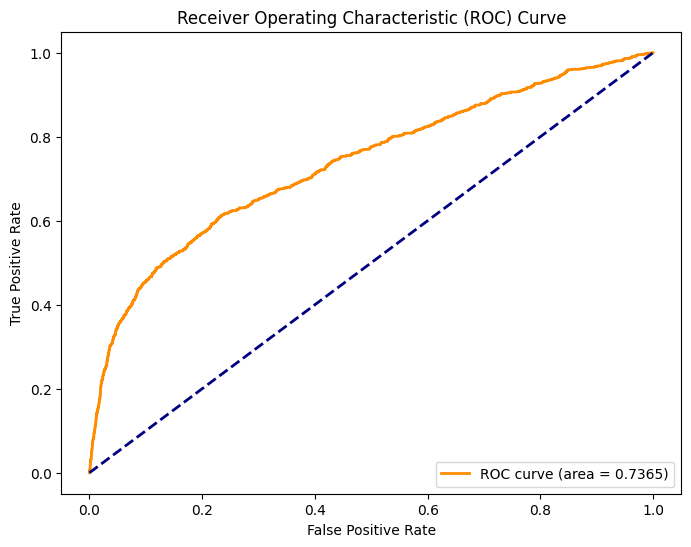

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the Neural Network model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Evaluate the model (for accuracy and classification report)
def evaluate_model(model, data_loader, device):
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())
    return accuracy_score(y_true, y_pred), y_true, y_pred

# Training with Early Stopping
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, device, epochs=20, patience=5):
    model.train()
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        epoch_loss = 0
        correct_train = 0
        total_train = 0
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == y_batch).sum().item()
            total_train += y_batch.size(0)
            
            epoch_loss += loss.item()

        # Calculate training accuracy
        train_accuracy = correct_train / total_train

        # Validate the model
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        # Early stopping condition
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break

# Hyperparameter tuning with SMOTE and Early Stopping
def tune_hyperparameters(X_train, y_train, X_test, y_test, hidden_sizes, learning_rates, batch_sizes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_accuracy = 0
    best_hyperparameters = {}

    # Split training data into training and validation sets
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    # Apply SMOTE on the training data to handle class imbalance
    smote = SMOTE(random_state=42)
    X_train_split_resampled, y_train_split_resampled = smote.fit_resample(X_train_split, y_train_split)

    for hidden_size in hidden_sizes:
        for lr in learning_rates:
            for batch_size in batch_sizes:
                # Create DataLoaders for training, validation, and testing
                train_dataset = TensorDataset(torch.tensor(X_train_split_resampled.values, dtype=torch.float32),
                                               torch.tensor(y_train_split_resampled.values, dtype=torch.long))
                val_dataset = TensorDataset(torch.tensor(X_val.values, dtype=torch.float32), 
                                             torch.tensor(y_val.values, dtype=torch.long))
                test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32),  
                                              torch.tensor(y_test.values, dtype=torch.long))

                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
                test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

                # Initialize the model
                model = NeuralNet(input_size=X_train.shape[1], hidden_size=hidden_size, output_size=2).to(device)
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=lr)

                # Train the model with early stopping
                train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, device)

                # Evaluate on validation set
                val_accuracy, _, _ = evaluate_model(model, val_loader, device)

                # Update best hyperparameters
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_hyperparameters = {'hidden_size': hidden_size, 'lr': lr, 'batch_size': batch_size}
                    # Save the best model
                    torch.save(model.state_dict(), "best_NN_model.pth")

                print(f"Hidden Size: {hidden_size}, LR: {lr}, Batch Size: {batch_size}, Val Accuracy: {val_accuracy:.4f}")

    # Load the best model and evaluate on test set
    best_model = NeuralNet(input_size=X_train.shape[1], hidden_size=best_hyperparameters['hidden_size'], output_size=2).to(device)
    best_model.load_state_dict(torch.load("best_NN_model.pth"))
    
    # Test Accuracy
    test_accuracy, y_true, y_pred = evaluate_model(best_model, test_loader, device)
    print(f"Best Hyperparameters: {best_hyperparameters}")
    print(f"Test Accuracy with Best Hyperparameters: {test_accuracy:.4f}")

    # Classification Report
    print("\nClassification Report on Test Set:")
    print(classification_report(y_true, y_pred))

    # ROC Curve and AUC Score
    y_prob = best_model(torch.tensor(X_test.values, dtype=torch.float32).to(device))
    y_prob = torch.softmax(y_prob, dim=1)[:, 1].cpu().detach().numpy()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Example hyperparameter values
hidden_sizes = [32, 64, 128]
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64]

# Assuming X_train, y_train, X_test, y_test are already prepared and normalized
tune_hyperparameters(X_train, y_train, X_test, y_test, hidden_sizes, learning_rates, batch_sizes)


pca 

# Save

In [18]:
# # Save the entire model
# torch.save(model.state_dict(), "best_model_full.pth")
# print("Full model saved successfully!")
